In [1]:
print("buenasera")

buenasera


In [8]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.model_selection import train_test_split
import seaborn as sns


In [9]:
train_df = pd.read_csv('training.csv') # split for test and train set is ready
test = pd.read_csv('test.csv')

In [22]:
our_columns = [1,10,11]+(list(range(18, 29))) + [31] + [12,14,15,16,17,29,30,31,32,33]
df = train_df.iloc[:,our_columns]

y = df["IsBadBuy"]
X = df

del X["IsBadBuy"]

In [23]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)


train = pd.DataFrame(X_train.join(y_train))
val = X_val.join(y_val)

In [24]:
val.head()

,Color,Transmission,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,...,VehOdo,Nationality,Size,TopThreeAmericanName,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost,IsBadBuy
10580,BLUE,AUTO,4516.0,5335.0,7121.0,8140.0,3941.0,4754.0,7531.0,8885.0,...,78883,OTHER ASIAN,MEDIUM,OTHER,77041,TX,5685.0,0,569,0
27667,GOLD,AUTO,8500.0,10607.0,9680.0,11956.0,8500.0,10607.0,9680.0,11956.0,...,79278,AMERICAN,CROSSOVER,CHRYSLER,32824,FL,6645.0,0,1857,0
60595,GREEN,AUTO,3402.0,4477.0,6513.0,7728.0,3844.0,4895.0,6620.0,7897.0,...,92111,AMERICAN,SMALL SUV,FORD,92337,CA,5480.0,0,1353,0
60484,RED,AUTO,9959.0,11383.0,11256.0,12794.0,10942.0,12387.0,12317.0,13878.0,...,85427,AMERICAN,MEDIUM SUV,CHRYSLER,91752,CA,8375.0,0,1763,0
48363,GOLD,AUTO,7026.0,8385.0,11809.0,13980.0,7642.0,9380.0,12049.0,14091.0,...,82274,AMERICAN,VAN,GM,47129,IN,6475.0,0,2282,0


In [25]:
train.columns

Index(['Color', 'Transmission', 'MMRAcquisitionAuctionAveragePrice',
       'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice',
       'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice',
       'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice',
       'MMRCurrentRetailCleanPrice', 'PRIMEUNIT', 'AUCGUART', 'BYRNO',
       'VehBCost', 'WheelTypeID', 'VehOdo', 'Nationality', 'Size',
       'TopThreeAmericanName', 'VNZIP1', 'VNST', 'VehBCost', 'IsOnlineSale',
       'WarrantyCost', 'IsBadBuy'],
      dtype='object')

In [26]:
train.groupby("Color")["IsBadBuy"].agg(["mean","count"]) # wygląda na to ze not avaiable color zwiększa szanse zlego zakupu, zas pomaranczowy kolor w dziwny sposob zmniejsza - ale jest tam dosyc malo danych

,mean,count
Color,,
BEIGE,0.139706,1088
BLACK,0.113936,5389
BLUE,0.115784,7229
BROWN,0.132890,301
GOLD,0.142626,3702
GREEN,0.118362,2222
GREY,0.116101,5478
MAROON,0.135135,1443
NOT AVAIL,0.253731,67


In [27]:
# na razie damy tylko kolumne czy jest bardziej niebezpieczna czy nie

color_train = train.groupby("Color")["IsBadBuy"].agg(["mean"]) 

max_mean_color = color_train["mean"].max()
color_dict = color_train["mean"].to_dict()
train["ColorDanger"] = train["Color"].map(color_dict).fillna(train.IsBadBuy.mean())/max_mean_color
bad_colors = list(color_train.loc[color_train["mean"] > train.IsBadBuy.mean()].index)

train['DangerousColor'] = np.where(train["Color"].isin(bad_colors), 1, 0)

In [41]:
# zaimputujemy sobie wartość 0 dla kolumn MMRCurrentAuctionAveragePrice oraz MMRAcquisitionAuctionAveragePrice
# pozostałe wywalamy
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

train["MMRCurrentAuctionAveragePrice"] = np.where(train["MMRCurrentAuctionAveragePrice"] == 0, np.nan, train["MMRCurrentAuctionAveragePrice"])
train["MMRAcquisitionAuctionAveragePrice"] = np.where(train["MMRAcquisitionAuctionAveragePrice"] == 0, np.nan, train["MMRAcquisitionAuctionAveragePrice"])

imp_mean = IterativeImputer(random_state=0)

MMR_columns = ["MMRCurrentAuctionAveragePrice", "MMRAcquisitionAuctionAveragePrice", "VehBCost"]

imp_mean.fit(train[["MMRCurrentAuctionAveragePrice", "MMRAcquisitionAuctionAveragePrice", "VehBCost"]])

MMR_train_transformed = imp_mean.transform(train[["MMRCurrentAuctionAveragePrice", "MMRAcquisitionAuctionAveragePrice", "VehBCost"]])

MMR_train_transformed

c:\Users\tymot\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


array([[ 6473.,  5602.,  6800.,  6800.],
       [ 8975.,  7038., 10775., 10775.],
       [ 6680.,  6680.,  6890.,  6890.],
       ...,
       [ 6346.,  5560.,  7130.,  7130.],
       [ 5345.,  5512.,  8370.,  8370.],
       [ 3426.,  2294.,  4910.,  4910.]])

# preprocessing pipeline

In [28]:
def preprocess_df(X):
    X['TopThreeAmericanName'] = X['TopThreeAmericanName'].fillna('OTHER')
    X['Size'] = X['Size'].fillna('MEDIUM')
    X['Nationality'] = X['Nationality'].fillna('OTHER')
    X = X[X['WheelTypeID'].notna()]
    X = X.drop(labels = ['VNZIP1','VNST'],axis=1)
        
    return X

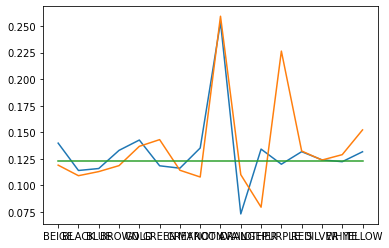

In [29]:
train_bad_buy_mean = train.IsBadBuy.mean()

color_val = val.groupby("Color")["IsBadBuy"].agg(["mean"])
color = color_val.join(color_train, lsuffix="_val", rsuffix="_train")
color["mean"] = train.IsBadBuy.mean()
plt.plot(color.index, color["mean_train"])
plt.plot(color.index, color["mean_val"])
plt.plot(color.index, color["mean"])

plt.show()

In [30]:
def encode_categorical(df):
    df["ColorDanger"] = df["Color"].map(color_dict).fillna(train_bad_buy_mean)/max_mean_color # no takie w miare to jest średnie
    #df['DangerousColor'] = np.where(df["Color"].isin(bad_colors), 1, 0)

    df["IsPrimeunitNA"] = np.where(df["PRIMEUNIT"].isna(), 1, 0) # to moze byc niepotrzebne
    primeunit_dict = {'NO':0, 'YES':1, float("nan"):0} # nie jestem pewien czy nie lepiej bedzie zamienic na odwrot
    df['PRIMEUNIT'] = df['PRIMEUNIT'].str.upper().map(primeunit_dict)
    aucguart_dict = {'GREEN':2, 'YELLOW':1, "RED":0, float("nan"):0}
    df['AUCGUART'] = df['AUCGUART'].str.upper().map(aucguart_dict)

    transmission_dict = {'AUTO':0, 'MANUAL':1}
    df['Transmission'] = df['Transmission'].str.upper().map(transmission_dict)
    df["Transmission"] = df["Transmission"].fillna(df["Transmission"].median())

    df = df.drop(columns=["BYRNO", "Color"])

    print("Categorical columns transformed.")

    return df

def impute_MMR(df):

    # zamieniamy 0 na nan    
    df["MMRCurrentAuctionAveragePrice"] = np.where(df["MMRCurrentAuctionAveragePrice"] == 0, np.nan, df["MMRCurrentAuctionAveragePrice"])
    df["MMRAcquisitionAuctionAveragePrice"] = np.where(df["MMRAcquisitionAuctionAveragePrice"] == 0, np.nan, df["MMRAcquisitionAuctionAveragePrice"])

    MMR_df = imp_mean.transform(df[["MMRCurrentAuctionAveragePrice", "MMRAcquisitionAuctionAveragePrice", "VehBCost"]])
    MMR_df = pd.DataFrame(MMR_df, columns = ["MMRCurrentAuctionAveragePrice", "MMRAcquisitionAuctionAveragePrice", "VehBCost"])
    MMR_df.index = df.index
    df["MMRCurrentAuctionAveragePrice"] = MMR_df["MMRCurrentAuctionAveragePrice"]
    df["MMRAcquisitionAuctionAveragePrice"] = MMR_df["MMRAcquisitionAuctionAveragePrice"]

    df = df.drop(columns = ["MMRAcquisitionAuctionCleanPrice", "MMRAcquisitionRetailAveragePrice", "MMRAcquisitonRetailCleanPrice", 
                            "MMRCurrentAuctionCleanPrice", "MMRCurrentRetailAveragePrice", "MMRCurrentRetailCleanPrice"]) 
    
    # tutaj moze tez MMRAcquisitionAuctionAveragePrice

    print("MMR Columns imputed.")
    return df

In [31]:
def preprocess_df(X):
    X['TopThreeAmericanName'] = X['TopThreeAmericanName'].fillna('OTHER')
    X['Size'] = X['Size'].fillna('MEDIUM')
    X['Nationality'] = X['Nationality'].fillna('OTHER')
    X = X[X['WheelTypeID'].notna()]
    X = X.drop(labels = ['VNZIP1','VNST'],axis=1)
        
    return X

In [ ]:
from sklearn.preprocessing import StandardScaler, FunctionTransformer, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['VehOdo','VehBCost', 'WarrantyCost']),
        ('cat', OneHotEncoder(),  ['TopThreeAmericanName', 'WheelTypeID','Nationality','Size']),
        ('passthrough','passthrough', ['IsOnlineSale'])
    ])


In [ ]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

categorical_transformer = FunctionTransformer(encode_categorical)
MMR_imputer = FunctionTransformer(impute_MMR)
mateusz_transformer = FunctionTransformer(preprocess_df)

# all the afore declared processings applied
prepipe = Pipeline([
    ("preprocessor", preprocessor)
    ("transform_categorical", categorical_transformer),
    ("MMR_imputing", MMR_imputer)
])

In [ ]:
train = prepipe.fit_transform(train)